# Synthesis of a 3D cube

In this notebook we show how to use a configuration file to run Hazel in a 3D cube, both in serial and parallel modes.

## Serial mode
Let's use a snapshot of an MHD simulation and synthesise the Fe I doublet at 630 nm.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as pl
import hazel
import h5py
from astropy.io import fits
print(hazel.__version__)
label = ['I', 'Q', 'U', 'V']

2018.9.22


First read the file with the observations and build a file in the input format of Hazel2.

In [2]:
f = fits.open('/Users/aasensio/dl_database/milic/50G.ngrey.288x100x288_atmos_61.fits')[0].data
# 0 - log tau - do not change this
# 1 - height in cm - ignore this
# 2 - temperature - do change this any way you see fit , reasonable value is 3000 to 10000 maybe
# 3 - pressure, we need to agree whether to automaticlly determine this using Hydrostatic equilibrium
# 4 - ignore
# 5 - ignore
# 6 - ignore
# 7 - magnetic field in gauss, magnitude, 0 - few thousand
# 8 - microturbulent velocity in cm/s , currently zero, set it to something you think make sense
# 9- los velocity in cm/s, geometric notation (positive is upward)
# 10 - magnetic field inclination, in rad
# 11 - magnetic field azimuth, in rad, does not influence stokes I, ignore
print(f.shape)

(12, 288, 288, 61)


In [3]:
nx = 288
n_pixel = nx*nx
nz = 61

model_3d = np.zeros((n_pixel,nz,8), dtype=np.float64)
ff_3d = np.ones((n_pixel,), dtype=np.float64)
vmac_3d = np.zeros((n_pixel,), dtype=np.float64)

# logtau     T        Pe           vmic        v            Bx           By         Bz

fout = h5py.File('photospheres/model_photosphere.h5', 'w')
db_model = fout.create_dataset('model', model_3d.shape, dtype=np.float64)
db_ff = fout.create_dataset('ff', ff_3d.shape, dtype=np.float64)
db_vmac = fout.create_dataset('vmac', vmac_3d.shape, dtype=np.float64)
db_model[:,:,0] = f[0,0:nx,0:nx,::-1].reshape((n_pixel,nz))   # tau
db_model[:,:,1] = f[2,0:nx,0:nx,::-1].reshape((n_pixel,nz))   # T
db_model[:,:,2] = f[3,0:nx,0:nx,::-1].reshape((n_pixel,nz))   # Pe
db_model[:,:,3] = f[8,0:nx,0:nx,::-1].reshape((n_pixel,nz))   # vmic
db_model[:,:,4] = 1e-5*f[9,0:nx,0:nx,::-1].reshape((n_pixel,nz))   # v

B = f[7,0:nx,0:nx,::-1].reshape((n_pixel,nz))
thB = f[10,0:nx,0:nx,::-1].reshape((n_pixel,nz))
phiB = f[11,0:nx,0:nx,::-1].reshape((n_pixel,nz))

db_model[:,:,5] = B*np.cos(thB)*np.cos(phiB)   # Bx
db_model[:,:,6] = B*np.cos(thB)*np.sin(phiB)   # By
db_model[:,:,7] = B*np.sin(thB)   # Bz

db_ff[:] = ff_3d
db_vmac[:] = vmac_3d
fout.close()

So we are now ready for the synthesis. Let's print first the configuration file and then do a simple synthesis. The configuration file defines the observing angle, lines and parameters.

In [12]:
%cat conf_synth_parallel.ini

# Hazel configuration File

[Working mode]
Output file = output_synth.h5

# Topology
# Always photosphere and then chromosphere
# Photospheres are only allowed to be added with a filling factor
# Atmospheres share a filling factor if they are in parenthesis
# Atmospheres are one after the other with the -> operator

[Spectral regions]
    [[Region 1]]
    Name = spec1
    Topology = ph1
    LOS = 0.0, 0.0, 90.0
    Wavelength = 6300, 6303, 150
    Boundary condition = 1.0, 0.0, 0.0, 0.0       # I/Ic(mu=1), Q/Ic(mu=1), U/Ic(mu=1), V/Ic(mu=1)
    
[Atmospheres]

    [[Photosphere 1]]
        Name = ph1
        Reference atmospheric model = 'photospheres/model_photosphere.h5'
        Spectral region = spec1
        Wavelength = 6300, 6303
        Spectral lines = 200, 201

Let's synthesize these profiles in a non-MPI mode, which can be done directly in Python:

In [4]:
iterator = hazel.Iterator(use_mpi=False)
mod = hazel.Model('conf_synth_parallel.ini', working_mode='synthesis')
iterator.use_model(model=mod)
iterator.run_all_pixels()

100%|██████████| 900/900 [00:15<00:00, 57.02it/s]


In [ ]:
!mpiexec -n 8 python par_synth.py

We can now do some plots.

(npix,nrand,ncycle,nstokes,nlambda) -> (82944, 1, 1, 4, 150)


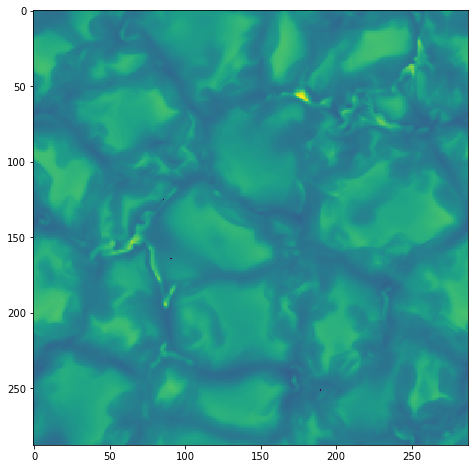

In [6]:
f = h5py.File('output_synth.h5', 'r')

print('(npix,nrand,ncycle,nstokes,nlambda) -> {0}'.format(f['spec1']['stokes'].shape))

fig, ax = pl.subplots(figsize=(8,8))
ax.imshow(f['spec1']['stokes'][:,0,0,0,0].reshape((nx,nx)))

f.close()

## Parallel mode
For inverting the profiles in a multi-core machine, you need to create a Python file (e.g., script.py) with the following content:

    iterator = hazel.Iterator(use_mpi=True)
    mod = hazel.Model('conf_spot_3d.ini', rank=iterator.get_rank())
    iterator.use_model(model=mod)
    iterator.run_all_pixels()
    
and run it with
    
    mpiexec -n n_cpu python script.py